In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



## Fig1e

In [20]:

cc = pd.read_csv("cell_group_abundance_by_sample.csv")
cc = cc.drop(columns=['Product','response_binary'], axis=2) #
cc['cell_group'] = cc['cell_group'].astype('string')
cc['cell_group'] = cc['cell_group'].str.replace("NKT","NK/T")
cc['cell_group'] = cc['cell_group'].str.replace("myeloid",'Myeloid')
cc['p'] = cc['abundance']/100

l2_groups = ['B', 'CD4 T', 'CD8 T', 'Myeloid', 'NK']  
cc['cell_type'] = pd.Categorical(cc['cell_type'], categories=l2_groups)

response_duration = pd.read_csv("sample_response_duration.csv")
print(response_duration.shape)
print(response_duration.columns.intersection(cc.columns))
cc_duration = pd.merge(cc, response_duration, how="left")
cc_duration['response_3m'] = cc_duration['response_3m'].apply(lambda x: 'HC' if pd.isna(x) else x)
cc_duration['disease_status'] = ['Malignant' if x in ['NR','PR', 'R'] else 'Healthy' for x in cc_duration['response_3m'] ]
cc_duration['disease_status'] = pd.Categorical(cc_duration['disease_status'], categories=['Healthy','Malignant'])
print(cc_duration.groupby('response_3m')['response_3m'].value_counts())

## group stats
group_stats_dict = {'NOV_response_3m': "./code/git/Fig1/cell_group_abundance_by_response_3m.NOV.stats.sccomp.csv",
                    'GIL_response_3m': "./code/git/Fig1/cell_group_abundance_by_response_3m.GIL.stats.sccomp.csv"}

## response df
df_response = cc_duration.loc[cc_duration['response_3m'].isin(['NR','R']),:]
df_response['Product'].value_counts()
print(df_response.shape)
print(df_response.head(3))


(44, 13)
Index(['sample_name'], dtype='object')
response_3m
HC     50
NR     65
R     150
Name: count, dtype: int64
(215, 23)
  patient_alias cell_type    n  n_patient_alias  abundance sample_id library  \
0        GIL_01         B    0             1799      0.000    GIL_01      10   
1        GIL_01     CD4 T  384             1799     21.345    GIL_01      10   
2        GIL_01     CD8 T  644             1799     35.798    GIL_01      10   

  cell_group sample_name        p  ...  clinical_response_1m response_binary  \
0          B      Axi-01  0.00000  ...                    NR              NR   
1       NK/T      Axi-01  0.21345  ...                    NR              NR   
2       NK/T      Axi-01  0.35798  ...                    NR              NR   

  Relapse_progression n_days_to_event n_months_to_event last_event  \
0                  NR            37.0          1.233333         ()   
1                  NR            37.0          1.233333         ()   
2                  NR 

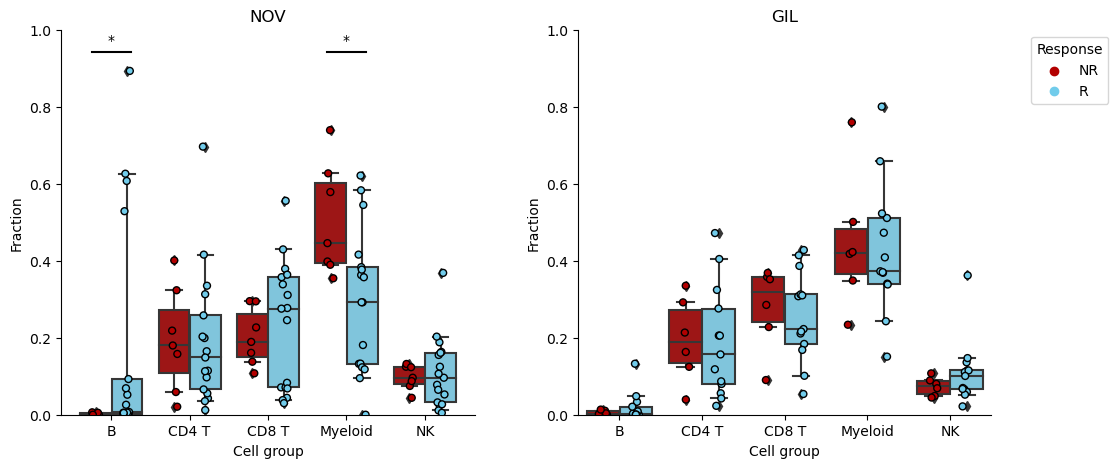

In [21]:
palette = {'NR':'#b30000','R':'#71cceb'} 

f,ax = plt.subplots(1,2,figsize=(12,5))

i=0
for Product in ['NOV', 'GIL']:
    
    group_frac = df_response.loc[df_response["Product"]==Product,:]
    #print(group_frac.head(2))
    
    if Product == "NOV":
        group_stats = pd.read_csv(group_stats_dict['NOV_response_3m'])
    elif Product == "GIL":
        group_stats = pd.read_csv(group_stats_dict['GIL_response_3m'])

    stat_frac = group_stats.loc[group_stats['factor'].notna(),:]
    
    ax[i] = sns.boxplot(x="cell_type",y="p",hue="response_3m",data=group_frac,whis=[5,95],palette=palette,ax=ax[i])
    
    sns.stripplot(x="cell_type",y="p",hue="response_3m",
                      data=group_frac,dodge=True,ax=ax[i],linewidth=1,jitter=True,edgecolor='k', palette=palette)

    ax[i].set_title(f'{Product}')
    ax[i].set_xlabel('Cell group')
    ax[i].set_ylabel('Fraction')

    #ax.set_xticklabels(plt.get_xticklabels(), rotation = 0)
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend(handles[2:], labels[2:], title='Response', bbox_to_anchor=(1, 1.2), loc='best')
    
    ## add p-values where significant
    y = max(df_response['p']) + 0.05
    for ig, group in enumerate(l2_groups):
        x1 = ig-0.25
        x2 = ig+0.25
        pval = stat_frac.loc[stat_frac['cell_type']==group,'c_FDR'].values[0]
        pval_s = "*" if pval < 0.05 else ""
        #pval_s = "p={:.2}".format(pval)
        h, col = 0.01, 'k'
        if pval < 0.05:
            ax[i].plot([x1, x2], [y, y], lw=1.5, c=col)
        ax[i].text((x1+x2)*.5, y+h, pval_s, ha='center', va='bottom', color=col)
    i+=1
     
for axi in ax:
    axi.set_ylim([0,1])
    axi.grid(False)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.get_legend().remove()
 
handles, labels = axi.get_legend_handles_labels()
axi.legend(handles[2:], labels[2:], title='Response', bbox_to_anchor=(1.3, 1), loc='upper right')
  
plt.subplots_adjust(wspace=0.25, hspace=0.25)
    

## Fig 1d

/tmp/ipykernel_595360/703024131.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)


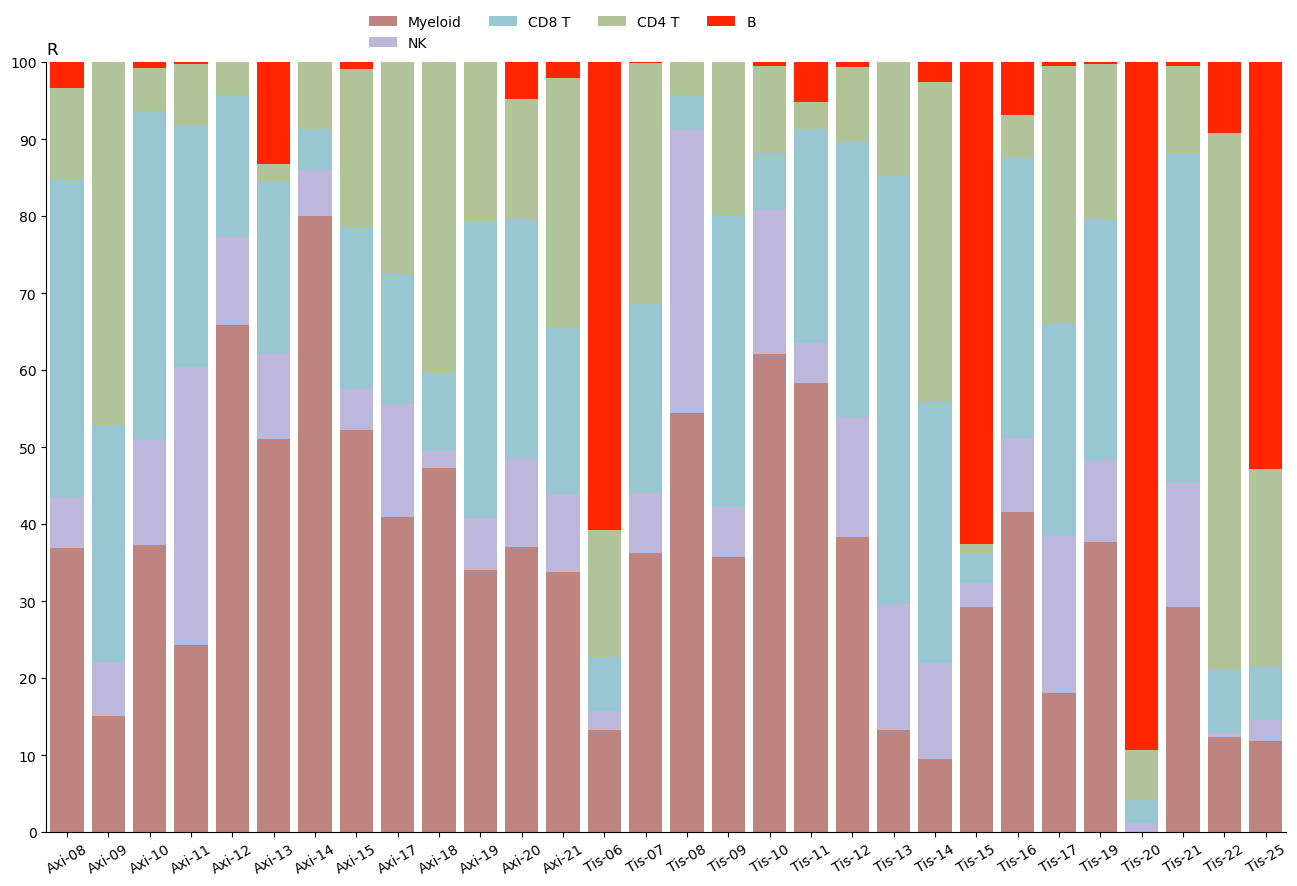

/tmp/ipykernel_595360/703024131.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)


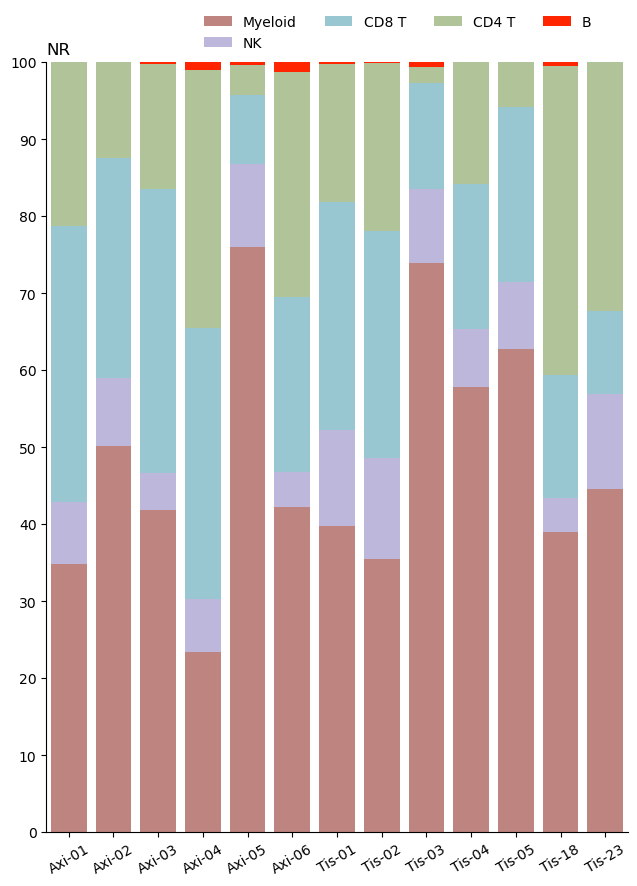

/tmp/ipykernel_595360/703024131.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)


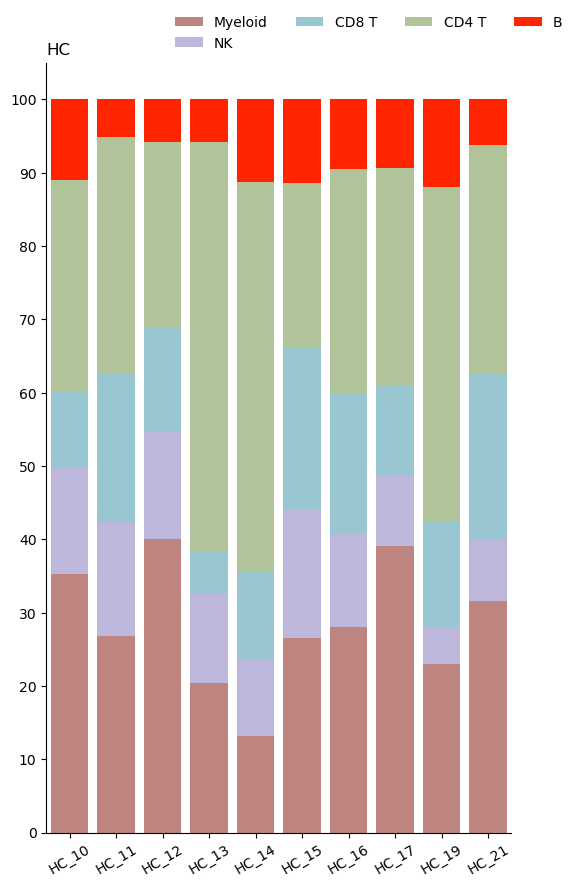

In [29]:


def plot_stackedbar_p(df, labels, colors, title = None, subtitle = None):
    
    fields = df.columns.tolist()
    n_samples = len(df)
    
    # figure and axis
    plt.close()
    fig, ax = plt.subplots(1, figsize=((n_samples*0.5)+1, 10))
    
    # plot bars
    bottom = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.bar(df.index, df[name], bottom = bottom, color=colors[idx])
        bottom = bottom + df[name]
        
    # title and subtitle
    plt.title(title, loc='left')
    plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
      
    plt.legend(labels, ncol=4, frameon=False, loc='best', bbox_to_anchor=([0.25, 1, 0, 0])) # 

    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # format ticks
    ylabels = np.arange(0,101,10)
    plt.yticks(ylabels)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
    
    # adjust limits and draw grid lines
    plt.xlim(-0.5, ax.get_xticks()[-1] + 0.5)

    plt.show()


fields = labels = ['B', 'CD4 T', 'CD8 T', 'NK', 'Myeloid'][::-1]
colors = ['#ff2500', '#B0C399', '#99c7d1',  '#bdb7db', '#bd8480' ][::-1] #'#e06666'   '#07d0c7',
for response in ['R', 'NR', "HC"]:  
    df = cc_duration.loc[cc_duration['response_3m']==response, ['sample_name','cell_type','abundance']]
    df = pd.pivot(df, index='sample_name', columns='cell_type', values='abundance').sort_index(ascending=True)
    df = df[fields]
    plot_stackedbar_p(df, labels, colors, title=response)
                


